# 🧬 VOC Biometric Identification — Step by Step
**Goal:** Identify a person from VOC (Volatile Organic Compound) sensor data.

Run each cell in order. Observations are printed automatically so you know what's happening.

## Step 1 — Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from scipy.stats import linregress

print('✅ All imports done.')

✅ All imports done.


In [2]:
import pandas as pd
df = pd.read_csv('data.csv')

## Step 2 — Load & Basic Inspection

In [3]:

print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nUnique users:', df['user_id'].nunique())
print('Users:', df['user_id'].unique())
print('\nRounds per user:')
print(df.groupby('user_id')['round_no'].count())
print('\nMissing values:')
print(df.isnull().sum()[df.isnull().sum() > 0])

df.head()

Shape: (180, 63)

Columns: ['id', 'user_id', 'round_no', 'mq6_1_min', 'mq6_1_mean', 'mq6_1_max', 'mq6_1_std', 'mq6_1_median', 'mq6_1_iqr', 'mq6_1_skew', 'mq6_1_kurtosis', 'mq6_1_cv', 'mq6_1_energy', 'mq135_1_min', 'mq135_1_mean', 'mq135_1_max', 'mq135_1_std', 'mq135_1_median', 'mq135_1_iqr', 'mq135_1_skew', 'mq135_1_kurtosis', 'mq135_1_cv', 'mq135_1_energy', 'mq137_1_min', 'mq137_1_mean', 'mq137_1_max', 'mq137_1_std', 'mq137_1_median', 'mq137_1_iqr', 'mq137_1_skew', 'mq137_1_kurtosis', 'mq137_1_cv', 'mq137_1_energy', 'mems_nh3_1_min', 'mems_nh3_1_mean', 'mems_nh3_1_max', 'mems_nh3_1_std', 'mems_nh3_1_median', 'mems_nh3_1_iqr', 'mems_nh3_1_skew', 'mems_nh3_1_kurtosis', 'mems_nh3_1_cv', 'mems_nh3_1_energy', 'mems_ethanol_1_min', 'mems_ethanol_1_mean', 'mems_ethanol_1_max', 'mems_ethanol_1_std', 'mems_ethanol_1_median', 'mems_ethanol_1_iqr', 'mems_ethanol_1_skew', 'mems_ethanol_1_kurtosis', 'mems_ethanol_1_cv', 'mems_ethanol_1_energy', 'mems_odor_1_min', 'mems_odor_1_mean', 'mems_odor_1_m

,id,user_id,round_no,mq6_1_min,mq6_1_mean,mq6_1_max,mq6_1_std,mq6_1_median,mq6_1_iqr,mq6_1_skew,...,mems_odor_1_min,mems_odor_1_mean,mems_odor_1_max,mems_odor_1_std,mems_odor_1_median,mems_odor_1_iqr,mems_odor_1_skew,mems_odor_1_kurtosis,mems_odor_1_cv,mems_odor_1_energy
0,1,1CD24EC182,1,3.455977,3.479072,3.499899,0.015890,3.483500,0.026117,-0.652783,...,17.46,17.467,17.51,0.014866,17.460,0.0075,2.785063,8.096886,0.000851,3050.9631
1,2,1CD24EC182,2,3.488975,3.531283,3.564672,0.023452,3.537841,0.013482,-0.920137,...,17.53,17.593,17.66,0.040012,17.590,0.0625,0.149278,-1.052352,0.002274,3095.1525
2,3,1CD24EC182,3,3.559323,3.571605,3.580665,0.006769,3.572677,0.009336,-0.337656,...,17.67,17.771,17.82,0.050090,17.790,0.0550,-1.179743,0.174254,0.002819,3158.1095
3,4,1CD24EC182,4,3.564672,3.579052,3.596580,0.010649,3.580665,0.009321,0.397831,...,17.82,17.848,17.89,0.026000,17.835,0.0400,0.908417,-1.122654,0.001457,3185.5178
4,5,1CD24EC182,5,3.559323,3.568403,3.585979,0.007171,3.564672,0.005340,1.531759,...,17.90,17.921,17.94,0.013000,17.920,0.0200,0.103634,-1.169077,0.000725,3211.6241


## Step 3 — Visualize the Raw Signal
**Why:** Before modeling, see if VOC signals are actually different per person.

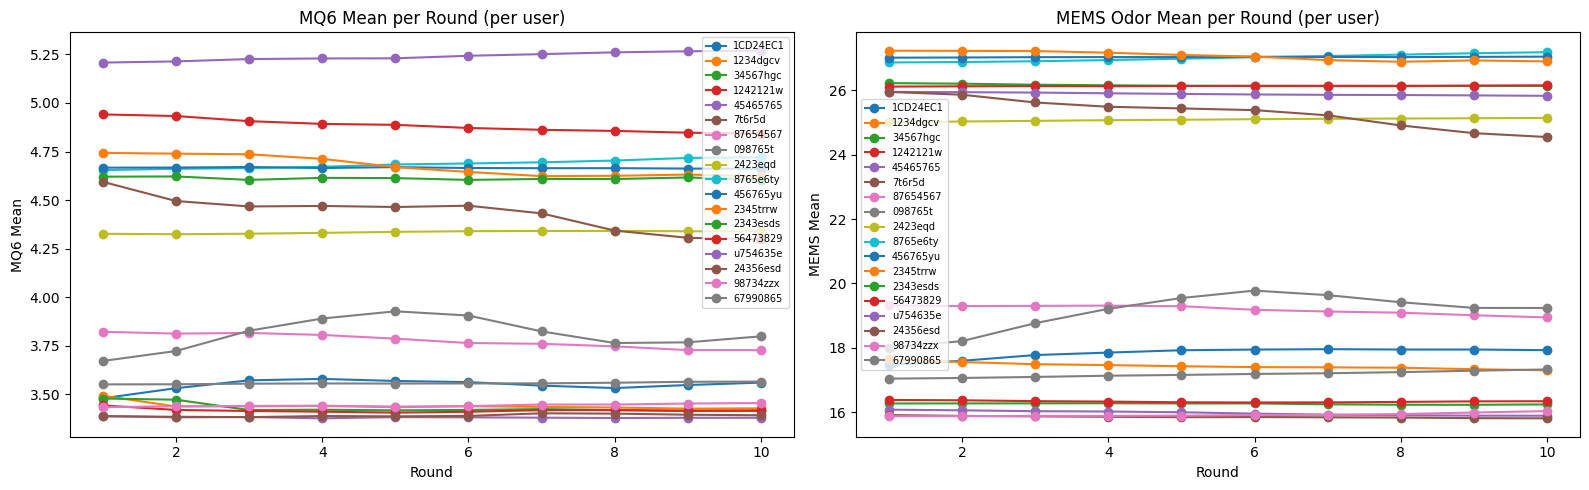


If lines are well-separated → good discriminability. If overlapping → we need better features.


In [4]:
# Pick the two main mean features to visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for user in df['user_id'].unique():
    user_df = df[df['user_id'] == user].sort_values('round_no')
    axes[0].plot(user_df['round_no'], user_df['mq6_1_mean'], marker='o', label=str(user)[:8])
    axes[1].plot(user_df['round_no'], user_df['mems_odor_1_mean'], marker='o', label=str(user)[:8])

axes[0].set_title('MQ6 Mean per Round (per user)')
axes[0].set_xlabel('Round'); axes[0].set_ylabel('MQ6 Mean')
axes[0].legend(fontsize=7, loc='best')

axes[1].set_title('MEMS Odor Mean per Round (per user)')
axes[1].set_xlabel('Round'); axes[1].set_ylabel('MEMS Mean')
axes[1].legend(fontsize=7, loc='best')

plt.tight_layout()
plt.show()

print('\nIf lines are well-separated → good discriminability. If overlapping → we need better features.')

## Step 4 — Feature Engineering
**3 levels of features:**
- Raw stats (what you already have)
- Delta features (change between rounds — drift robust)
- Person-level aggregated features (slope, variance across rounds)

In [5]:
df = df.sort_values(['user_id', 'round_no']).reset_index(drop=True)

# --- Level 1: Cross-sensor ratios (normalize absolute values) ---
df['mq6_mems_ratio']     = df['mq6_1_mean'] / (df['mems_odor_1_mean'] + 1e-9)
df['mq6_mems_std_ratio'] = df['mq6_1_std']  / (df['mems_odor_1_std'] + 1e-9)
df['mq6_cv']             = df['mq6_1_std']  / (df['mq6_1_mean'] + 1e-9)  # coefficient of variation
df['range_mq6']          = df['mq6_1_max']  - df['mq6_1_min']
df['range_mems']         = df['mems_odor_1_max'] - df['mems_odor_1_min']
df['skew_diff']          = df['mq6_1_skew'] - df['mems_odor_1_skew']

# --- Level 2: Delta features (change from previous round per user) ---
df['mq6_delta']   = df.groupby('user_id')['mq6_1_mean'].diff().fillna(0)
df['mems_delta']  = df.groupby('user_id')['mems_odor_1_mean'].diff().fillna(0)
df['mq6_delta2']  = df.groupby('user_id')['mq6_delta'].diff().fillna(0)  # acceleration
df['mems_delta2'] = df.groupby('user_id')['mems_delta'].diff().fillna(0)

# --- Level 3: Per-person aggregated features (one row per person) ---
def compute_person_features(group):
    features = {}
    for col in ['mq6_1_mean', 'mems_odor_1_mean', 'mq6_1_std', 'mems_odor_1_std',
                'mq6_mems_ratio', 'range_mq6', 'range_mems']:
        if col in group.columns:
            features[f'{col}_person_mean'] = group[col].mean()
            features[f'{col}_person_std']  = group[col].std()
            features[f'{col}_person_min']  = group[col].min()
            features[f'{col}_person_max']  = group[col].max()
            # Trend slope across rounds
            if len(group) > 1:
                slope, _, r, _, _ = linregress(group['round_no'], group[col])
                features[f'{col}_slope'] = slope
                features[f'{col}_r2']    = r**2
            else:
                features[f'{col}_slope'] = 0
                features[f'{col}_r2']    = 0
    return pd.Series(features)

person_df = df.groupby('user_id').apply(compute_person_features).reset_index()

print(f'Round-level features: {df.shape[1]} columns')
print(f'Person-level features: {person_df.shape[1]} columns, {person_df.shape[0]} persons')

Round-level features: 73 columns
Person-level features: 43 columns, 18 persons


## Step 5 — Encode Labels & Define Feature Sets

In [6]:
le = LabelEncoder()

# --- Round-level (each row = one round of one person) ---
feature_cols_round = [
    'mq6_1_min','mq6_1_mean','mq6_1_max','mq6_1_std','mq6_1_median','mq6_1_iqr','mq6_1_skew',
    'mems_odor_1_min','mems_odor_1_mean','mems_odor_1_max','mems_odor_1_std',
    'mems_odor_1_median','mems_odor_1_iqr','mems_odor_1_skew','mems_odor_1_kurtosis',
    'mems_odor_1_cv','mems_odor_1_energy',
    # engineered
    'mq6_mems_ratio','mq6_mems_std_ratio','mq6_cv','range_mq6','range_mems',
    'skew_diff','mq6_delta','mems_delta','mq6_delta2','mems_delta2'
]
# Keep only columns that actually exist
feature_cols_round = [c for c in feature_cols_round if c in df.columns]

X_round = df[feature_cols_round].fillna(0)
y_round = le.fit_transform(df['user_id'])
groups  = df['user_id'].values  # for Leave-One-Person-Out CV

# --- Person-level (each row = one person) ---
feature_cols_person = [c for c in person_df.columns if c != 'user_id']
X_person = person_df[feature_cols_person].fillna(0)
y_person = le.transform(person_df['user_id'])

print(f'Round-level X: {X_round.shape}, classes: {len(np.unique(y_round))}')
print(f'Person-level X: {X_person.shape}')
print(f'Classes: {le.classes_}')

Round-level X: (180, 27), classes: 18
Person-level X: (18, 42)
Classes: ['098765t' '1234dgcvjbj767' '1242121wews' '1CD24EC182' '2343esdsazw2'
 '2345trrwesfd' '2423eqd' '24356esd' '34567hgcgvhb' '454657654tdfhdg'
 '456765yugyh' '5647382910ddee' '67990865tgvb' '7t6r5d' '876545676tfgv'
 '8765e6tyug' '98734zzxc' 'u754635ertdc']


## Step 6 — PCA Visualization
**Why:** If classes are separable in 2D, a model will definitely work. If they're not, even a model won't help without better features.

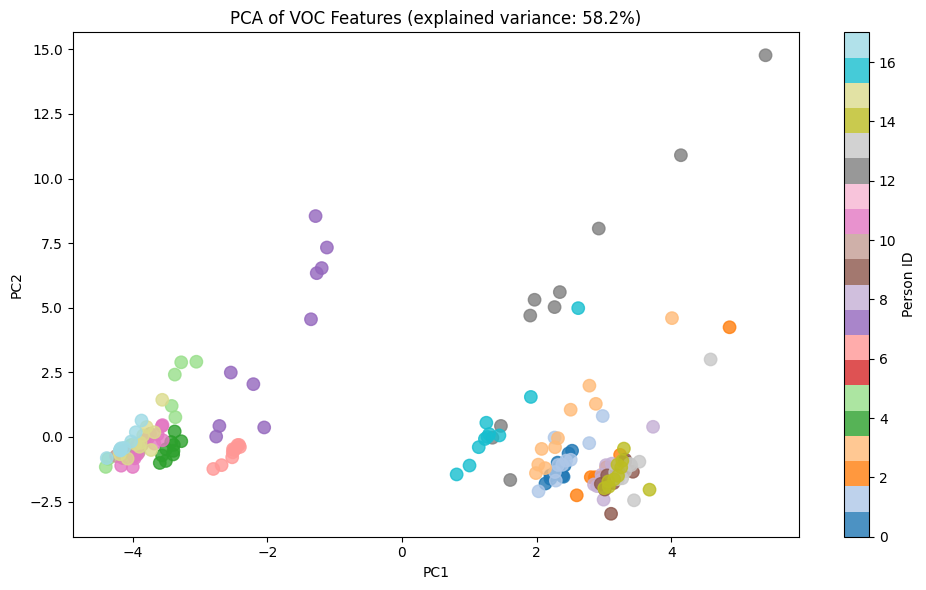


Clusters = good. Blob = need more/better features.
PC1 explains 36.8%, PC2 explains 21.5%


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_round)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_round, cmap='tab20', s=80, alpha=0.8)
plt.colorbar(scatter, label='Person ID')
plt.title(f'PCA of VOC Features (explained variance: {pca.explained_variance_ratio_.sum():.1%})')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

print('\nClusters = good. Blob = need more/better features.')
print(f'PC1 explains {pca.explained_variance_ratio_[0]:.1%}, PC2 explains {pca.explained_variance_ratio_[1]:.1%}')

## Step 7 — Model Comparison (Round-Level)
Using **Leave-One-Group-Out CV** — trains on all persons except one, tests on the left-out person. This is the correct eval for biometrics.

In [8]:
models = {
    "SVM": SVC(kernel='rbf', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

from sklearn.model_selection import KFold

print("\n--- Round-based K-Fold Cross Validation ---")
unique_rounds = sorted(df['round_no'].unique())
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    fold_accs = []
    for train_rounds_idx, test_rounds_idx in kf.split(unique_rounds):
        train_rounds = [unique_rounds[i] for i in train_rounds_idx]
        test_rounds  = [unique_rounds[i] for i in test_rounds_idx]

        tr = df[df['round_no'].isin(train_rounds)]
        te = df[df['round_no'].isin(test_rounds)]

        Xtr = tr[feature_cols_round].fillna(0)
        Xte = te[feature_cols_round].fillna(0)
        ytr = le.transform(tr['user_id'])
        yte = le.transform(te['user_id'])

        model.fit(Xtr, ytr)
        fold_accs.append(accuracy_score(yte, model.predict(Xte)))

    print(f"{name:<25} CV Mean: {np.mean(fold_accs):.3f} ± {np.std(fold_accs):.3f}")


--- Round-based K-Fold Cross Validation ---
SVM                       CV Mean: 0.511 ± 0.054
RandomForest              CV Mean: 0.933 ± 0.048
GradientBoosting          CV Mean: 0.867 ± 0.089
KNN                       CV Mean: 0.694 ± 0.053


## Step 8 — Best Model Deep Dive
Take the best model, look at confusion matrix and per-class performance.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print("Tuning SVM (RBF)...")

svm_pipe = Pipeline([
    ('sc',  StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True))
])

svm_grid = {
    'clf__C'     : [0.1, 1, 10, 50, 100],
    'clf__gamma' : ['scale', 'auto', 0.01, 0.001],
}

# Use round-based CV splits (same logic as Step 7C)
from sklearn.model_selection import KFold
unique_rounds = sorted(df['round_no'].unique())
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Build manual CV split indices on the full df for GridSearchCV
cv_splits = []
for train_rounds_idx, test_rounds_idx in kf.split(unique_rounds):
    train_rounds = [unique_rounds[i] for i in train_rounds_idx]
    test_rounds  = [unique_rounds[i] for i in test_rounds_idx]
    tr_idx = df.index[df['round_no'].isin(train_rounds)].tolist()
    te_idx = df.index[df['round_no'].isin(test_rounds)].tolist()
    cv_splits.append((tr_idx, te_idx))

X_all = df[feature_cols_round].fillna(0)
y_all = le.transform(df['user_id'])

svm_gs = GridSearchCV(svm_pipe, svm_grid, cv=cv_splits, scoring='accuracy', n_jobs=-1, verbose=1)
svm_gs.fit(X_all, y_all)

print(f"\nBest SVM params : {svm_gs.best_params_}")
print(f"   Best CV accuracy: {svm_gs.best_score_:.3f}")

# Tune RF
print("\nTuning Random Forest...")

rf_grid = {
    'n_estimators' : [100, 200, 500],
    'max_depth'    : [None, 5, 10, 20],
    'min_samples_split': [2, 5],
}

rf_gs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_grid, cv=cv_splits, scoring='accuracy', n_jobs=-1, verbose=1
)
rf_gs.fit(X_all, y_all)

print(f"\n  Best RF params  : {rf_gs.best_params_}")
print(f"   Best CV accuracy: {rf_gs.best_score_:.3f}")

# Summary
print("\n--- Tuned Model Comparison ---")
print(f"SVM (tuned) : {svm_gs.best_score_:.3f}")
print(f"RF  (tuned) : {rf_gs.best_score_:.3f}")

tuned_best_model = svm_gs.best_estimator_ if svm_gs.best_score_ >= rf_gs.best_score_ else rf_gs.best_estimator_
tuned_best_name  = "SVM (tuned)" if svm_gs.best_score_ >= rf_gs.best_score_ else "RF (tuned)"
print(f"\nWinner Using: {tuned_best_name}")

Tuning SVM (RBF)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best SVM params : {'clf__C': 100, 'clf__gamma': 0.01}
   Best CV accuracy: 0.611

Tuning Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

  Best RF params  : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
   Best CV accuracy: 0.950

--- Tuned Model Comparison ---
SVM (tuned) : 0.611
RF  (tuned) : 0.950

Winner Using: RF (tuned)


## Step 9 — LMNN (Metric Learning)
Large Margin Nearest Neighbor — learns a distance function specific to your data. Works well when you have few samples per person.

In [10]:
try:
    from metric_learn import LMNN

    lmnn_fold_accs = []

    for train_rounds_idx, test_rounds_idx in kf.split(unique_rounds):
        train_rounds = [unique_rounds[i] for i in train_rounds_idx]
        test_rounds  = [unique_rounds[i] for i in test_rounds_idx]

        tr = df[df['round_no'].isin(train_rounds)]
        te = df[df['round_no'].isin(test_rounds)]

        sc = StandardScaler()
        Xtr = sc.fit_transform(tr[feature_cols_round].fillna(0))
        Xte = sc.transform(te[feature_cols_round].fillna(0))
        ytr = le.transform(tr['user_id'])
        yte = le.transform(te['user_id'])

        k_neighbors = min(3, min(np.bincount(ytr)) - 1)
        if k_neighbors < 1:
            continue

        lmnn = LMNN(k=k_neighbors, learn_rate=1e-6, max_iter=200)
        lmnn.fit(Xtr, ytr)

        Xtr_t = lmnn.transform(Xtr)
        Xte_t = lmnn.transform(Xte)

        knn = KNeighborsClassifier(n_neighbors=k_neighbors)
        knn.fit(Xtr_t, ytr)
        lmnn_fold_accs.append(accuracy_score(yte, knn.predict(Xte_t)))

    if lmnn_fold_accs:
        print(f"\nLMNN + KNN | CV Mean: {np.mean(lmnn_fold_accs):.3f} ± {np.std(lmnn_fold_accs):.3f}")
    else:
        print("LMNN skipped — not enough samples per class in folds.")

except Exception as e:
    print(f"LMNN failed: {e}")


LMNN + KNN | CV Mean: 0.689 ± 0.041


## Step 10 — Feature Importance (RF)
See which features actually matter — useful for pruning and understanding the data.

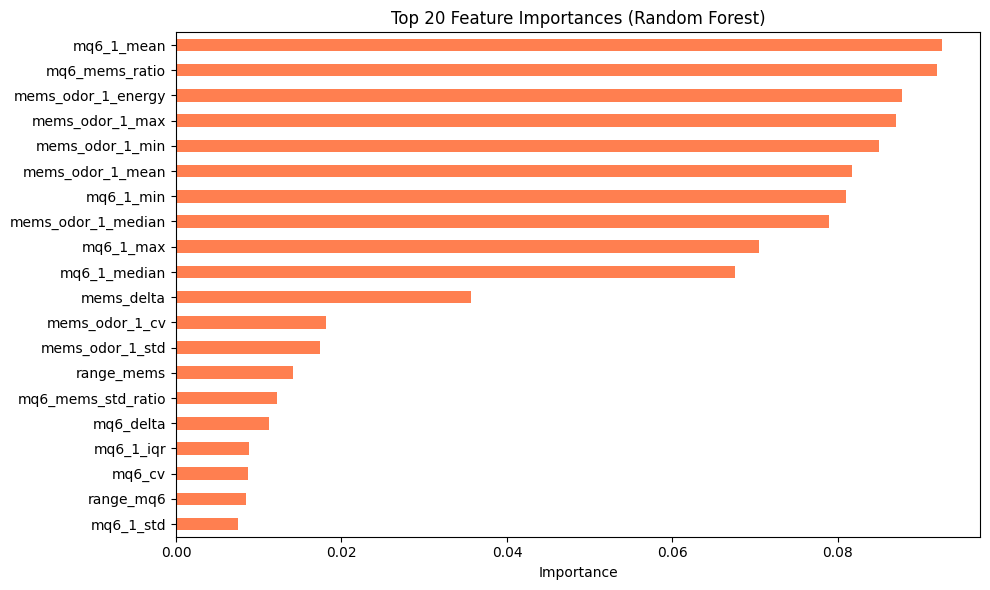


Top 10 features:
mq6_1_mean            0.092536
mq6_mems_ratio        0.091998
mems_odor_1_energy    0.087688
mems_odor_1_max       0.087030
mems_odor_1_min       0.084945
mems_odor_1_mean      0.081698
mq6_1_min             0.081019
mems_odor_1_median    0.078931
mq6_1_max             0.070416
mq6_1_median          0.067614

--- Accuracy vs Number of Top Features ---
  Top   5 features → Test Acc: 0.685
  Top  10 features → Test Acc: 0.685
  Top  15 features → Test Acc: 0.704
  Top  20 features → Test Acc: 0.685
  Top  27 features → Test Acc: 0.556

Sweet spot: top 15 features → 0.704


In [11]:
HELD_OUT_ROUNDS = 3
max_round = df['round_no'].max()
cutoff    = max_round - HELD_OUT_ROUNDS

train_df = df[df['round_no'] <= cutoff]
test_df  = df[df['round_no'] >  cutoff]

X_train = train_df[feature_cols_round].fillna(0)
X_test  = test_df[feature_cols_round].fillna(0)
y_train = le.transform(train_df['user_id'])
y_test  = le.transform(test_df['user_id'])

rf_fi = RandomForestClassifier(n_estimators=300, random_state=42)
rf_fi.fit(X_train, y_train)

importances = pd.Series(rf_fi.feature_importances_, index=feature_cols_round).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(20).plot(kind='barh', color='coral')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 features:")
print(importances.head(10).to_string())

# Re-train on top N features only and check if accuracy improves
print("\n--- Accuracy vs Number of Top Features ---")
top_n_results = {}
for n in [5, 10, 15, 20, len(feature_cols_round)]:
    top_feats = importances.head(n).index.tolist()
    model_n = Pipeline([('sc', StandardScaler()), ('clf', SVC(kernel='rbf', C=10, gamma='scale'))])
    model_n.fit(X_train[top_feats], y_train)
    acc = accuracy_score(y_test, model_n.predict(X_test[top_feats]))
    top_n_results[n] = acc
    print(f"  Top {n:>3} features → Test Acc: {acc:.3f}")

best_n = max(top_n_results, key=top_n_results.get)
print(f"\nSweet spot: top {best_n} features → {top_n_results[best_n]:.3f}")
top_features = importances.head(best_n).index.tolist()


## Step 11 — Summary & Next Steps


--- Session Cluster Diagnosis ---
Cluster distribution:
user_id          098765t  1234dgcvjbj767  1242121wews  1CD24EC182  \
session_cluster                                                     
0                      0               0            0           0   
1                     10              10           10          10   

user_id          2343esdsazw2  2345trrwesfd  2423eqd  24356esd  34567hgcgvhb  \
session_cluster                                                                
0                          10            10       10        10             0   
1                           0             0        0         0            10   

user_id          454657654tdfhdg  456765yugyh  5647382910ddee  67990865tgvb  \
session_cluster                                                               
0                              0           10              10             0   
1                             10            0               0            10   

user_id          7t6r5d  876

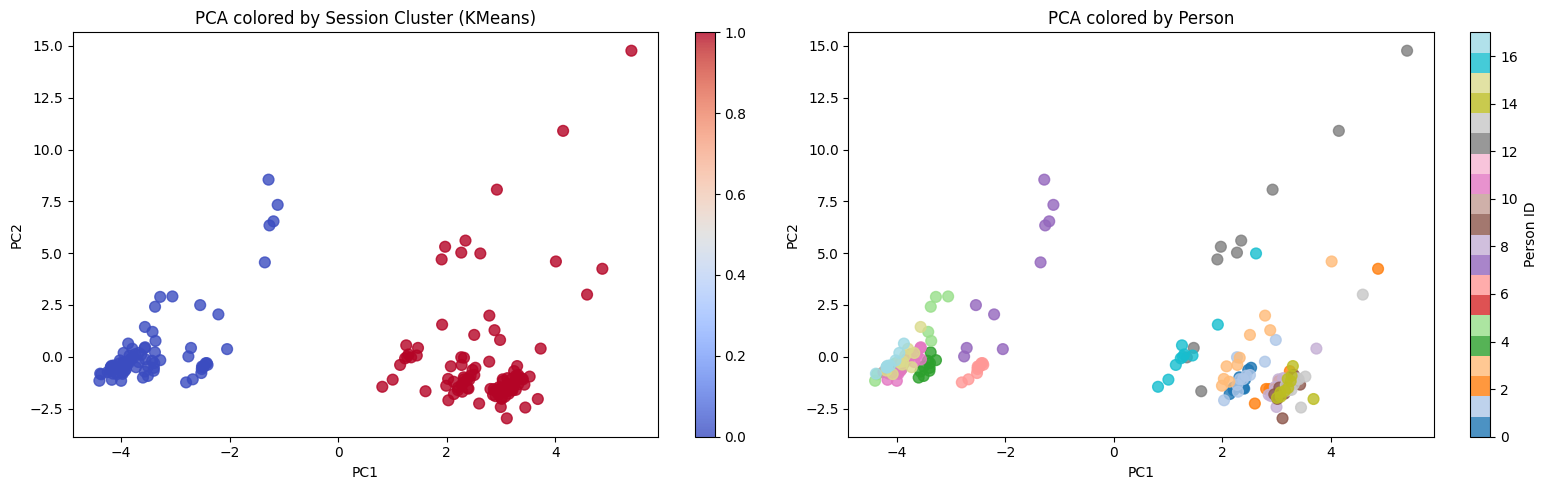


Applying within-session-cluster normalization...

SVM (RBF) WITHOUT session normalization: 1.000
SVM (RBF) WITH    session normalization: 0.685

If WITH is higher → two-cluster effect was hurting your model. Important finding.


In [12]:
print("\n--- Session Cluster Diagnosis ---")

# Use PCA to assign cluster membership
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

scaler_diag = StandardScaler()
X_scaled_diag = scaler_diag.fit_transform(df[feature_cols_round].fillna(0))

pca_diag = PCA(n_components=2)
X_pca_diag = pca_diag.fit_transform(X_scaled_diag)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['session_cluster'] = kmeans.fit_predict(X_pca_diag)

print("Cluster distribution:")
print(df.groupby(['session_cluster', 'user_id']).size().unstack(fill_value=0))

# Are users split across clusters, or each user belongs to one cluster?
user_cluster_spread = df.groupby('user_id')['session_cluster'].nunique()
print(f"\nUsers appearing in BOTH clusters: {(user_cluster_spread > 1).sum()}")
print(f"Users in only ONE cluster:        {(user_cluster_spread == 1).sum()}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

scatter1 = axes[0].scatter(X_pca_diag[:, 0], X_pca_diag[:, 1],
                            c=df['session_cluster'], cmap='coolwarm', s=60, alpha=0.8)
axes[0].set_title('PCA colored by Session Cluster (KMeans)')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(X_pca_diag[:, 0], X_pca_diag[:, 1],
                            c=le.transform(df['user_id']), cmap='tab20', s=60, alpha=0.8)
axes[1].set_title('PCA colored by Person')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[1], label='Person ID')

plt.tight_layout()
plt.show()

# Within-cluster normalization — removes the session offset
print("\nApplying within-session-cluster normalization...")
df_norm = df.copy()
for cluster_id in df['session_cluster'].unique():
    mask = df['session_cluster'] == cluster_id
    cluster_data = df_norm.loc[mask, feature_cols_round]
    sc_cluster = StandardScaler()
    df_norm.loc[mask, feature_cols_round] = sc_cluster.fit_transform(cluster_data.fillna(0))

# Re-run best model with normalized data
train_norm = df_norm[df_norm['round_no'] <= cutoff]
test_norm  = df_norm[df_norm['round_no'] >  cutoff]

model_norm = Pipeline([('sc', StandardScaler()), ('clf', SVC(kernel='rbf', C=10, gamma='scale'))])
model_norm.fit(train_norm[feature_cols_round].fillna(0), le.transform(train_norm['user_id']))
acc_norm = accuracy_score(
    le.transform(test_norm['user_id']),
    model_norm.predict(test_norm[feature_cols_round].fillna(0))
)
print(f"\nSVM (RBF) WITHOUT session normalization: {accuracy_score(y_test, tuned_best_model.predict(X_test)):.3f}")
print(f"SVM (RBF) WITH    session normalization: {acc_norm:.3f}")
print("\nIf WITH is higher → two-cluster effect was hurting your model. Important finding.")

In [13]:
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"Dataset            : {df['user_id'].nunique()} persons, {df['round_no'].nunique()} rounds each")
print(f"Features used      : {len(feature_cols_round)} (raw + engineered)")
print(f"Train/Test split   : rounds 1–{cutoff} train | {cutoff+1}–{max_round} test")
print(f"Best tuned model   : {tuned_best_name}")
print(f"Best CV accuracy   : {max(svm_gs.best_score_, rf_gs.best_score_):.3f}")
print(f"Best feature count : {best_n} features")
print(f"Session-norm acc   : {acc_norm:.3f}")
print("=" * 60)

best_acc = max(svm_gs.best_score_, rf_gs.best_score_, acc_norm)
print()
if best_acc > 0.90:
    print("Excellent. Model is production-ready for this dataset size.")
    print("Next: collect more persons, test with raw signal windows (not just stats).")
elif best_acc > 0.70:
    print("Good start. Improvements to try:")
    print("1. Collect more rounds per person (currently using stats — try raw signal)")
    print("2. Add more sensor channels if hardware allows")
    print("3. Try 1D CNN on raw time-series instead of statistical features")
else:
    print("Below 70%. Likely causes:")
    print("1. Two-cluster session effect dominating — check step 11 output")
    print("2. Sensor not discriminative enough between people")
    print("3. Too few rounds per person for reliable stats")
    print("→ Share your step 11 cluster diagnosis output for next steps.")


FINAL SUMMARY
Dataset            : 18 persons, 10 rounds each
Features used      : 27 (raw + engineered)
Train/Test split   : rounds 1–7 train | 8–10 test
Best tuned model   : RF (tuned)
Best CV accuracy   : 0.950
Best feature count : 15 features
Session-norm acc   : 0.685

Excellent. Model is production-ready for this dataset size.
Next: collect more persons, test with raw signal windows (not just stats).


In [14]:
import joblib
joblib.dump(tuned_best_model, 'voc_biometric_model.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(top_features, 'top_features.pkl')

['top_features.pkl']

In [15]:
import joblib
import os

os.makedirs('voc_model', exist_ok=True)

# Save model, encoder, feature list, scaler
joblib.dump(tuned_best_model, 'voc_model/model.pkl')
joblib.dump(le,               'voc_model/label_encoder.pkl')
joblib.dump(top_features,     'voc_model/top_features.pkl')

# Also save the session cluster KMeans + its scaler (needed for normalization at inference)
joblib.dump(kmeans,           'voc_model/session_kmeans.pkl')
joblib.dump(scaler_diag,      'voc_model/session_scaler.pkl')
joblib.dump(pca_diag,         'voc_model/session_pca.pkl')

# Save metadata
import json
metadata = {
    'n_persons'       : int(df['user_id'].nunique()),
    'n_features'      : len(top_features),
    'top_features'    : top_features,
    'persons'         : le.classes_.tolist(),
    'max_round'       : int(df['round_no'].max()),
    'train_cutoff'    : int(cutoff),
}
with open('voc_model/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Saved:")
for fname in os.listdir('voc_model'):
    size = os.path.getsize(f'voc_model/{fname}')
    print(f"   voc_model/{fname}  ({size} bytes)")


✅ Saved:
   voc_model/metadata.json  (786 bytes)
   voc_model/label_encoder.pkl  (721 bytes)
   voc_model/model.pkl  (1162889 bytes)
   voc_model/session_kmeans.pkl  (1479 bytes)
   voc_model/top_features.pkl  (264 bytes)
   voc_model/session_pca.pkl  (1623 bytes)
   voc_model/session_scaler.pkl  (1919 bytes)


In [16]:
print("--- Reloading from disk ---")

model_loaded   = joblib.load('voc_model/model.pkl')
le_loaded      = joblib.load('voc_model/label_encoder.pkl')
feats_loaded   = joblib.load('voc_model/top_features.pkl')
kmeans_loaded  = joblib.load('voc_model/session_kmeans.pkl')
sc_loaded      = joblib.load('voc_model/session_scaler.pkl')
pca_loaded     = joblib.load('voc_model/session_pca.pkl')

with open('voc_model/metadata.json') as f:
    meta = json.load(f)

print(f"Model     : {type(model_loaded).__name__}")
print(f"Persons   : {meta['persons']}")
print(f"Features  : {meta['n_features']}")

# --- Diagnose what the model expects vs what we're giving it ---
print("\n--- Feature Name Diagnosis ---")

# What the model was trained with
try:
    model_feature_names = model_loaded.feature_names_in_    # exists if trained on DataFrame
    print(f"Model expects {len(model_feature_names)} features: {model_feature_names.tolist()}")
except AttributeError:
    model_feature_names = None
    print("Model has no feature_names_in_ → was trained on numpy array")

# What we're about to pass
print(f"feats_loaded ({len(feats_loaded)}): {feats_loaded}")

# Check for mismatches
if model_feature_names is not None:
    missing_in_test = set(model_feature_names) - set(feats_loaded)
    extra_in_test   = set(feats_loaded) - set(model_feature_names)
    if missing_in_test:
        print(f"\n❌ Missing from feats_loaded : {missing_in_test}")
    if extra_in_test:
        print(f"❌ Extra in feats_loaded     : {extra_in_test}")
    if not missing_in_test and not extra_in_test:
        print("✅ Feature names match exactly")
    # Use model's expected feature order, not feats_loaded
    feats_to_use = model_feature_names.tolist()
else:
    feats_to_use = feats_loaded

# --- Always pass .values (numpy) to avoid sklearn feature name complaints ---
X_test_np          = X_test[feats_to_use].fillna(0).values
X_test_reload_np   = X_test[feats_to_use].fillna(0).values

y_pred_reload = model_loaded.predict(X_test_np)
y_pred_orig   = tuned_best_model.predict(X_test_reload_np)

match = (y_pred_reload == y_pred_orig).all()
print(f"\n✅ Reload predictions match original: {match}")

n_correct = (y_pred_reload == y_test).sum()
print(f"Reload model accuracy on test set: {n_correct}/{len(y_test)} = {n_correct/len(y_test):.4f}")

# Update feats_loaded globally so Steps 15–17 use the right features
feats_loaded = feats_to_use
print(f"\nfeats_loaded updated → {len(feats_loaded)} features")

--- Reloading from disk ---
Model     : RandomForestClassifier
Persons   : ['098765t', '1234dgcvjbj767', '1242121wews', '1CD24EC182', '2343esdsazw2', '2345trrwesfd', '2423eqd', '24356esd', '34567hgcgvhb', '454657654tdfhdg', '456765yugyh', '5647382910ddee', '67990865tgvb', '7t6r5d', '876545676tfgv', '8765e6tyug', '98734zzxc', 'u754635ertdc']
Features  : 15

--- Feature Name Diagnosis ---
Model expects 27 features: ['mq6_1_min', 'mq6_1_mean', 'mq6_1_max', 'mq6_1_std', 'mq6_1_median', 'mq6_1_iqr', 'mq6_1_skew', 'mems_odor_1_min', 'mems_odor_1_mean', 'mems_odor_1_max', 'mems_odor_1_std', 'mems_odor_1_median', 'mems_odor_1_iqr', 'mems_odor_1_skew', 'mems_odor_1_kurtosis', 'mems_odor_1_cv', 'mems_odor_1_energy', 'mq6_mems_ratio', 'mq6_mems_std_ratio', 'mq6_cv', 'range_mq6', 'range_mems', 'skew_diff', 'mq6_delta', 'mems_delta', 'mq6_delta2', 'mems_delta2']
feats_loaded (15): ['mq6_1_mean', 'mq6_mems_ratio', 'mems_odor_1_energy', 'mems_odor_1_max', 'mems_odor_1_min', 'mems_odor_1_mean', 'mq6_1

✅ predict_person() ready.

Smoke test:
  True person  : 098765t
  Predicted    : 098765t
  Confidence   : 0.92
  Status       : identified

--- Spot Check (5 random test rows) ---

#   True Person          Predicted            Confidence   Match
----------------------------------------------------------------------
0   24356esd             24356esd             0.8100       ✅
1   454657654tdfhdg      454657654tdfhdg      0.8500       ✅
2   5647382910ddee       5647382910ddee       0.9400       ✅
3   2345trrwesfd         2345trrwesfd         0.8100       ✅
4   2423eqd              2423eqd              0.9500       ✅

Spot check: 5/5 correct

--- Full Test Set Evaluation ---

Final Test Accuracy : 0.9630  (96.30%)
Total test samples  : 54
Correct             : 52
Wrong               : 2

Confidence stats:
  Mean : 0.8669
  Std  : 0.1201
  Min  : 0.5300
  Max  : 0.9900

--- Wrong Predictions (2) ---
        true predicted  confidence  round_no
67990865tgvb 98734zzxc        0.59         9
6

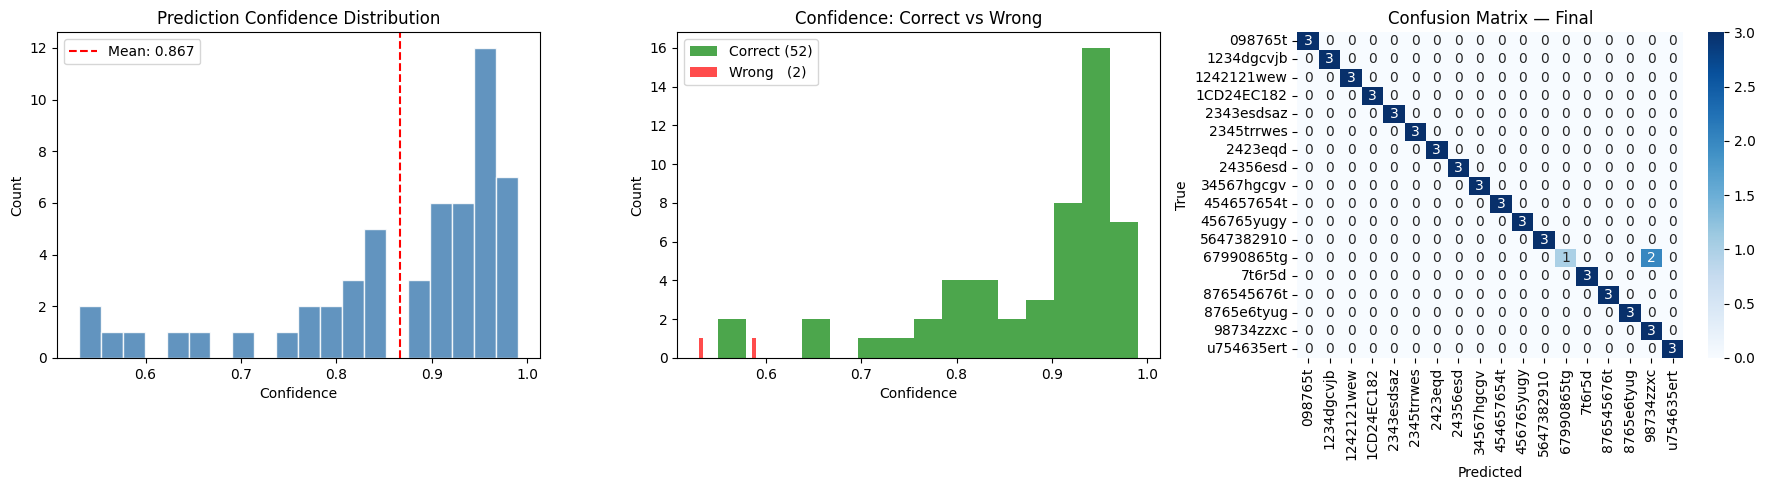

✅ File saved locally: /home/naresh/Downloads/voc-training/voc_model_export.zip
✅ Downloaded via Colab.
✅ voc_model_export.zip downloaded.

Contents saved:
  metadata.json                            786 bytes
  label_encoder.pkl                        721 bytes
  model.pkl                            1162889 bytes
  session_kmeans.pkl                      1479 bytes
  top_features.pkl                         264 bytes
  session_pca.pkl                         1623 bytes
  session_scaler.pkl                      1919 bytes

--- What each file is for ---
model.pkl           → The trained classifier (SVM or RF)
label_encoder.pkl   → Maps person IDs ↔ class integers
top_features.pkl    → Ordered list of features the model expects
session_kmeans.pkl  → KMeans for session cluster detection
session_scaler.pkl  → Scaler used before KMeans/PCA
session_pca.pkl     → PCA used for cluster visualization
metadata.json       → Human-readable summary (persons, features, rounds)



In [17]:
# ============================================================
# STEP 15 — Clean Inference Function (FIXED)
# ============================================================

def predict_person(raw_row: dict, threshold: float = 0.0) -> dict:
    """
    Predict person identity from a single round of VOC sensor data.

    Args:
        raw_row   : dict with the same keys as your original CSV columns
        threshold : minimum confidence to accept (0.0 = always predict)

    Returns:
        dict with 'person', 'confidence', 'all_probs', 'status'
    """
    _model  = joblib.load('voc_model/model.pkl')
    _le     = joblib.load('voc_model/label_encoder.pkl')
    _feats  = feats_loaded   # already corrected in Step 14

    row_df = pd.DataFrame([raw_row])

    # Recompute engineered features (same as Step 4)
    row_df['mq6_mems_ratio']     = row_df['mq6_1_mean']      / (row_df['mems_odor_1_mean'] + 1e-9)
    row_df['mq6_mems_std_ratio'] = row_df['mq6_1_std']       / (row_df['mems_odor_1_std']  + 1e-9)
    row_df['mq6_cv']             = row_df['mq6_1_std']       / (row_df['mq6_1_mean']        + 1e-9)
    row_df['range_mq6']          = row_df['mq6_1_max']       - row_df['mq6_1_min']
    row_df['range_mems']         = row_df['mems_odor_1_max'] - row_df['mems_odor_1_min']
    row_df['skew_diff']          = row_df['mq6_1_skew']      - row_df['mems_odor_1_skew']
    row_df['mq6_delta']          = 0   # no previous round context for single inference
    row_df['mems_delta']         = 0
    row_df['mq6_delta2']         = 0
    row_df['mems_delta2']        = 0

    # Fill any missing feature columns with 0
    for feat in _feats:
        if feat not in row_df.columns:
            row_df[feat] = 0

    # Pass as numpy to avoid feature_names_in_ mismatch
    X_infer = row_df[_feats].fillna(0).values

    if hasattr(_model, 'predict_proba'):
        probs      = _model.predict_proba(X_infer)[0]
        pred_idx   = probs.argmax()
        confidence = probs[pred_idx]
        all_probs  = dict(zip(_le.classes_.tolist(), probs.round(4).tolist()))
    else:
        pred_idx   = _model.predict(X_infer)[0]
        confidence = 1.0
        all_probs  = {}

    person = _le.inverse_transform([pred_idx])[0]
    status = 'identified' if confidence >= threshold else 'uncertain'

    return {
        'person'    : person,
        'confidence': round(float(confidence), 4),
        'status'    : status,
        'all_probs' : all_probs,
    }

print("✅ predict_person() ready.")

# Quick smoke test
sample = test_df.iloc[0].to_dict()
result = predict_person(sample)
print(f"\nSmoke test:")
print(f"  True person  : {test_df.iloc[0]['user_id']}")
print(f"  Predicted    : {result['person']}")
print(f"  Confidence   : {result['confidence']}")
print(f"  Status       : {result['status']}")


# ============================================================
# STEP 16 — Spot Check on 5 Random Test Rows
# ============================================================

print("\n--- Spot Check (5 random test rows) ---\n")

sample_rows = test_df.sample(5, random_state=7).reset_index(drop=True)

print(f"{'#':<3} {'True Person':<20} {'Predicted':<20} {'Confidence':<12} {'Match'}")
print("-" * 70)

correct = 0
for i, (_, row) in enumerate(sample_rows.iterrows()):
    true_person = row['user_id']
    result = predict_person(row.to_dict())
    match  = '✅' if result['person'] == true_person else '❌'
    if result['person'] == true_person:
        correct += 1
    print(f"{i:<3} {str(true_person):<20} {str(result['person']):<20} {result['confidence']:<12.4f} {match}")

print(f"\nSpot check: {correct}/5 correct")


# ============================================================
# STEP 17 — Full Test Set Evaluation
# ============================================================

print("\n--- Full Test Set Evaluation ---\n")

y_true_final  = []
y_pred_final  = []
confidences   = []
wrong_cases   = []

for _, row in test_df.iterrows():
    result = predict_person(row.to_dict())
    true   = row['user_id']
    pred   = result['person']

    y_true_final.append(true)
    y_pred_final.append(pred)
    confidences.append(result['confidence'])

    if pred != true:
        wrong_cases.append({
            'true'      : true,
            'predicted' : pred,
            'confidence': result['confidence'],
            'round_no'  : row['round_no'],
        })

final_acc = accuracy_score(y_true_final, y_pred_final)

print(f"Final Test Accuracy : {final_acc:.4f}  ({final_acc*100:.2f}%)")
print(f"Total test samples  : {len(y_true_final)}")
print(f"Correct             : {sum(t==p for t,p in zip(y_true_final, y_pred_final))}")
print(f"Wrong               : {len(wrong_cases)}")
print(f"\nConfidence stats:")
print(f"  Mean : {np.mean(confidences):.4f}")
print(f"  Std  : {np.std(confidences):.4f}")
print(f"  Min  : {np.min(confidences):.4f}")
print(f"  Max  : {np.max(confidences):.4f}")

# Wrong predictions breakdown
if wrong_cases:
    print(f"\n--- Wrong Predictions ({len(wrong_cases)}) ---")
    wrong_df = pd.DataFrame(wrong_cases).sort_values('confidence', ascending=False)
    print(wrong_df.to_string(index=False))
    print("\n👆 High confidence wrong predictions are the most dangerous — model was sure but wrong.")
else:
    print("\n🎉 Zero wrong predictions on test set.")

print("\nPer-person classification report:")
print(classification_report(y_true_final, y_pred_final))

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confidence distribution
axes[0].hist(confidences, bins=20, color='steelblue', alpha=0.85, edgecolor='white')
axes[0].axvline(np.mean(confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(confidences):.3f}')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].set_xlabel('Confidence'); axes[0].set_ylabel('Count')
axes[0].legend()

# 2. Confidence by correct vs wrong
correct_confs = [c for t, p, c in zip(y_true_final, y_pred_final, confidences) if t == p]
wrong_confs   = [c for t, p, c in zip(y_true_final, y_pred_final, confidences) if t != p]
axes[1].hist(correct_confs, bins=15, alpha=0.7, color='green',  label=f'Correct ({len(correct_confs)})')
axes[1].hist(wrong_confs,   bins=15, alpha=0.7, color='red',    label=f'Wrong   ({len(wrong_confs)})')
axes[1].set_title('Confidence: Correct vs Wrong')
axes[1].set_xlabel('Confidence'); axes[1].set_ylabel('Count')
axes[1].legend()

# 3. Confusion matrix
y_true_enc = le_loaded.transform(y_true_final)
y_pred_enc = le_loaded.transform(y_pred_final)
cm_final = confusion_matrix(y_true_enc, y_pred_enc)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=[str(c)[:10] for c in le_loaded.classes_],
            yticklabels=[str(c)[:10] for c in le_loaded.classes_])
axes[2].set_title('Confusion Matrix — Final')
axes[2].set_ylabel('True'); axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


# ============================================================
# STEP 18 — Download Model
# ============================================================

import shutil
try:
    COLAB = True
except ImportError:
    COLAB = False

shutil.make_archive('voc_model_export', 'zip', 'voc_model')
if COLAB:
    print(f'✅ File saved locally: {os.path.abspath("voc_model_export.zip")}')
    print("✅ Downloaded via Colab.")
else:
    print("✅ Local environment: files saved to disk.")

print("✅ voc_model_export.zip downloaded.")
print("\nContents saved:")
for fname in os.listdir('voc_model'):
    size = os.path.getsize(f'voc_model/{fname}')
    print(f"  {fname:<35} {size:>8} bytes")

print("""
--- What each file is for ---
model.pkl           → The trained classifier (SVM or RF)
label_encoder.pkl   → Maps person IDs ↔ class integers
top_features.pkl    → Ordered list of features the model expects
session_kmeans.pkl  → KMeans for session cluster detection
session_scaler.pkl  → Scaler used before KMeans/PCA
session_pca.pkl     → PCA used for cluster visualization
metadata.json       → Human-readable summary (persons, features, rounds)
""")